In [2]:
import networkx as nx
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from tqdm import tqdm
from itertools import combinations
from collections import defaultdict, deque
import math, random
import heapq
import scipy.sparse as sp
from collections import deque
from joblib import Parallel, delayed
from typing import Tuple, Dict, List, Set, Sequence, Union
import itertools
from typing import Any
import math
import heapq

import networkx as nx
import numpy as np
from numba import njit, prange

# 0. Component Sampling EPC

In [3]:
def sigma_exact(
    G: nx.Graph,
    S: set,
    use_tqdm: bool = False
) -> int:
    from itertools import product
    edges = list(G.edges())
    total_conn = 0.0

    for state in product([0,1], repeat=len(edges)):
        p_state = 1
        Gp = nx.Graph()
        Gp.add_nodes_from(set(G.nodes())-S)

        for (e, keep) in zip(edges, state):
            p_edge = G.edges[e]['p']
            p_state *= (p_edge if keep else (1-p_edge))

            if keep and e[0] not in S and e[1] not in S:
                Gp.add_edge(*e)

        # count connected i<j pairs in Gp−S
        for i,j in combinations(set(G.nodes())-S, 2):
            if nx.has_path(Gp, i, j):
                total_conn += p_state

    return total_conn

In [4]:
def component_sampling_epc_mc(G, S, num_samples=10_000,
                              epsilon=None, delta=None, use_tqdm=False):
  """
  Theoretic bounds: compute N = N(epsilon, delta) by the theoretical bound.
  Experimentation:  Otherwise, use the N as input for sample count.
  """

  # Surviving vertex set and its size
  V_remaining = set(G.nodes()) - S
  n_rem = len(V_remaining)

  # base case
  if n_rem < 2:
    return 0.0

  if num_samples is None:
    assert epsilon is not None and delta is not None
    P_E = sum(G.edges[u, v]['p'] for u, v in G.edges())
    coeff = 4 * (math.e - 2) * math.log(2 / delta)
    num_samples = math.ceil(coeff * n_rem * (n_rem - 1) /
                            (epsilon ** 2 * P_E))

  C2 = 0
  it = tqdm(range(num_samples), desc='Component sampling',
            total=num_samples) if use_tqdm else range(num_samples)

  for _ in it:
    u = random.choice(tuple(V_remaining))

    # BFS based on edge probabilities

    visited = {u}
    queue = [u]

    while queue:

      v = queue.pop()
      for w in G.neighbors(v):

        # flip a coin biased by the edge probability
        # w not in deleted nodes
        if w in V_remaining and random.random() < G.edges[v, w]['p']:

          # if w is not visited
          if w not in visited:
              visited.add(w)
              queue.append(w)

    # component counting
    C2 += (len(visited) - 1)

  return (n_rem * C2) / (2 * num_samples)

## 0.1 Optimized EPC

In [11]:
def nx_to_csr(G: nx.Graph) -> Tuple[List[int], Dict[int, int], np.ndarray, np.ndarray, np.ndarray]:
     """Convert an undirected NetworkX graph (edge attr `'p'`) to CSR arrays."""
     nodes: List[int] = list(G.nodes())
     idx_of: Dict[int, int] = {u: i for i, u in enumerate(nodes)}

     indptr: List[int] = [0]
     indices: List[int] = []
     probs: List[float] = []

     for u in nodes:
         for v in G.neighbors(u):
             indices.append(idx_of[v])
             probs.append(G.edges[u, v]['p'])
         indptr.append(len(indices))

     return (
         nodes,
         idx_of,
         np.asarray(indptr, dtype=np.int32),
         np.asarray(indices, dtype=np.int32),
         np.asarray(probs, dtype=np.float32),
     )

@njit(inline="always")
def _bfs_component_size(start: int,
                    indptr: np.ndarray,
                    indices: np.ndarray,
                    probs: np.ndarray,
                    deleted: np.ndarray) -> int:
    """Return |C_u|−1 for **one** random realisation (stack BFS)."""
    n = deleted.size
    stack = np.empty(n, dtype=np.int32)
    visited = np.zeros(n, dtype=np.uint8)

    size = 1
    top = 0
    stack[top] = start
    top += 1
    visited[start] = 1

    while top:
        top -= 1
        v = stack[top]
        for eid in range(indptr[v], indptr[v + 1]):
            w = indices[eid]
            if deleted[w]:
                continue
            if np.random.random() >= probs[eid]:
                continue
            if visited[w]:
                continue
            visited[w] = 1
            stack[top] = w
            top += 1
            size += 1
    return size - 1

@njit(parallel=True)
def epc_mc(indptr: np.ndarray,
            indices: np.ndarray,
            probs: np.ndarray,
            deleted: np.ndarray,
            num_samples: int) -> float:
    """Monte‑Carlo estimator of **expected pairwise connectivity** (EPC)."""
    surv = np.where(~deleted)[0]
    m = surv.size
    if m < 2:
        return 0.0

    acc = 0.0
    for _ in prange(num_samples):
        u = surv[np.random.randint(m)]
        acc += _bfs_component_size(u, indptr, indices, probs, deleted)

    return (m * acc) / (2.0 * num_samples)

def epc_mc_deleted(
  G: nx.Graph,
  S: set,
  num_samples: int = 100_000,
) -> float:
  # build csr once
  nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
  n = len(nodes)

  # turn python set S into a mask (node-IDs to delete)
  deleted = np.zeros(n, dtype=np.bool_)
  for u in S:
    deleted[idx_of[u]] = True

  epc = epc_mc(indptr, indices, probs, deleted, num_samples)

  return epc

# 1. Greedy+EPC optimized

In [49]:
def greedy_cndp_epc_celf(
    G: nx.Graph,
    k: int,
    *,
    num_samples: int = 100_000,
    reuse_csr: Tuple = None,
    return_trace: bool = False,
) -> Union[Set[int], Tuple[Set[int], List[float]]]:
    """
    Select **k** nodes that minimise EPC using CELF & Numba.
    """

    if reuse_csr is None:
        nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
    else:
        nodes, idx_of, indptr, indices, probs = reuse_csr
    n = len(nodes)

    deleted = np.zeros(n, dtype=np.bool_)
    current_sigma = epc_mc(indptr, indices, probs, deleted, num_samples)

    pq: List[Tuple[float, int, int]] = []
    gains = np.empty(n, dtype=np.float32)

    for v in range(n):
        deleted[v] = True
        gains[v] = current_sigma - epc_mc(indptr, indices, probs, deleted, num_samples)
        deleted[v] = False
        heapq.heappush(pq, (-gains[v], v, 0))

    S: Set[int] = set()
    trace: List[float] = []
    round_ = 0

    trace.append(current_sigma)

    while len(S) < k and pq:
        neg_gain, v, last = heapq.heappop(pq)
        if last == round_:
            # gain up‑to‑date → accept
            S.add(nodes[v])
            deleted[v] = True
            current_sigma += neg_gain
            round_ += 1
            if return_trace:
                trace.append(current_sigma)
        else:
            # recompute gain lazily
            deleted[v] = True
            new_gain = current_sigma - epc_mc(indptr, indices, probs, deleted, num_samples)
            deleted[v] = False
            heapq.heappush(pq, (-new_gain, v, round_))

    return (S, trace) if return_trace else S

def optimise_epc(
    G: nx.Graph,
    k: int,
    *,
    num_samples: int = 100_000,
    return_trace: bool = False,
 ) -> Union[Set[int], Tuple[Set[int], List[float]]]:
    csr = nx_to_csr(G)
    return greedy_cndp_epc_celf(G, k, num_samples=num_samples, reuse_csr=csr, return_trace=return_trace)

In [54]:
def local_search_swap(
  # G: nx.Graph,
  S: Set[int],
  *,
  csr: Tuple[List[int], Dict[int,int], np.ndarray, np.ndarray, np.ndarray],
  num_samples: int = 100_000,
  max_iter: int = 5
) -> Set[int]:
  """
  Given initial delete-set S, try 1-for-1 swaps to reduce EPC.
  csr = (nodes, idx_of, indptr, indices, probs).
  """
  nodes, idx_of, indptr, indices, probs = csr
  n = len(nodes)

  # build boolean mask from S
  deleted = np.zeros(n, dtype=np.bool_)
  for u in S:
    deleted[idx_of[u]] = True

  # current EPC
  curr = epc_mc(indptr, indices, probs, deleted, num_samples)

  for it in tqdm(range(max_iter), desc="local search", total=max_iter):
    best_delta = 0.0
    best_swap = None

    # try swapping each i in S with each j not in S
    for i in list(S):
      ii = idx_of[i]
      # undelete i
      deleted[ii] = False

      for j in nodes:
        jj = idx_of[j]
        if deleted[jj]:
          continue
        # delete j
        deleted[jj] = True

        sigma = epc_mc(indptr, indices, probs, deleted, num_samples)
        delta = curr - sigma
        if delta > best_delta:
          best_delta = delta
          best_swap = (ii, jj, sigma)

        # revert j
        deleted[jj] = False

      # revert i

      deleted[ii] = True

    if best_swap is None:
      break   

    # commit the best swap
    ii, jj, new_sigma = best_swap
    deleted[ii] = False
    deleted[jj] = True
    curr = new_sigma

    # update S
    S.remove(nodes[ii])
    S.add(nodes[jj])

  return S

In [ ]:
def greedy_es_local_opt(
    G, K,
    num_samples=100_000, local_iter=5, return_trace=True
):
  G_greedy_es, sigma_delta = optimise_epc(
    G=G, k=K, num_samples=num_samples, return_trace=return_trace)

  # epc_greedy_es = component_sampling_epc_mc(G_greedy_es, set(), N_SAMPLE)
  epc_greedy_es = sigma_delta[-1]

  csr = nx_to_csr(G)

  S_opt = local_search_swap(
    G_greedy_es, csr=csr, 
    num_samples=num_samples, max_iter=local_iter)

  epc_final = epc_mc_deleted(G, S_opt, num_samples)

  return epc_greedy_es, epc_final

In [58]:
SEED = 42
N_SAMPLE = 100_000

K = 10
NODES = 100
G = nx.erdos_renyi_graph(NODES, 0.0443, seed=SEED)

p = 0.9

for u, v in G.edges():
  G[u][v]['p'] = p

mean_epc, std_epc = greedy_es_local_opt(
  G, K, num_samples=N_SAMPLE,
  local_iter=5, return_trace=True)

mean_epc, std_epc

local search: 100%|██████████| 5/5 [10:10<00:00, 122.01s/it]


(np.float32(3036.5042), 2788.95465)

# 2. Greedy+EPC (non-optimized)

In [7]:
def greedy_cndp_epc(
    G: nx.Graph,
    K: int,
    num_samples: int = 100_000,
    exact: bool = False,
    use_tqdm: bool = False
) -> set:
  """
  Algorithm 2 from the paper: Greedy selection of S |S| <= K
  to minimize sigma(S) via sigma_monte_carlo().

  Returns the list S (in pick order).
  """

  # S <= {Empty set} init
  S = set()

  Sigma_delta = []
  # Current sigma(S) for the empty set
  sigma_S = 0
  if exact:
    sigma_S = sigma_exact(G, S)
  else:
    sigma_S = component_sampling_epc_mc(G, S, num_samples=num_samples)

  Sigma_delta.append(sigma_S)
  # print(f"Initial sigma(S): {sigma_S}")

  if use_tqdm:
    it = tqdm(range(K), desc='Greedy selection', total=K)
  else:
    it = range(K)

  # Greedily select K nodes
  for _ in it:
    # inits
    best_j = None
    best_gain = -float('inf')
    best_sigma = None

    # find v maximizing gain sigma(S) - sigma(S ∪ j)
    for j in G:
      # Skip if j is already in S to avoid redundant calculations
      # j ∈ S
      if j in S:
        continue

      # S ∪ j = S + {j}
      if exact:
        sigma_Sj = sigma_exact(G, S | {j})
      else:
        sigma_Sj = component_sampling_epc_mc(G, S | {j}, num_samples=num_samples)

      gain = sigma_S - sigma_Sj

      # j <= argmax_{j ∈ V\S} (sigma(S) - sigma(S ∪ j))

      if gain > best_gain:
        best_gain = gain
        best_j = j
        best_sigma = sigma_Sj


    # add the best node
    if best_j is None:
      break

    S.add(best_j)
    sigma_S = best_sigma

    Sigma_delta.append(best_sigma)
    # print(f"Selected node {best_j}, gain: {best_gain}, new sigma(S): {sigma_S}")

  return S, Sigma_delta

# 3. Betweenness, PageRank, Degree-based

In [8]:
def remove_k_betweenness(G: nx.Graph, k: int) -> nx.Graph:
  bc = nx.betweenness_centrality(G)
  topk = sorted(bc, key=bc.get, reverse=True)[:k]
  H = G.copy()
  H.remove_nodes_from(topk)
  return H

# def remove_k_pagerank_edges(G: nx.Graph, k: int) -> nx.Graph:
#   L = nx.line_graph(G)
#   pr = nx.pagerank(L)
#   topk = sorted(pr, key=pr.get, reverse=True)[:k]
#   H = G.copy()
#   H.remove_edges_from(topk)
#   return H

def remove_k_pagerank_nodes(
    G: nx.Graph,
    k: int,
    *,
    pagerank_kwargs: Dict[str, Any] | None = None,
) -> nx.Graph:
    """
    Return a copy of *G* after deleting the k nodes with the
    highest PageRank scores.

    Parameters
    ----------
    G : nx.Graph
        Input graph (directed or undirected).
    k : int
        Number of nodes to delete.
    pagerank_kwargs : dict, optional
        Extra keyword arguments forwarded to ``nx.pagerank``;
        e.g. ``alpha=0.85``, ``weight="weight"``, ``max_iter=100`` …
        Leave empty to accept NetworkX defaults.

    Notes
    -----
    * On an **undirected** graph, PageRank reduces to a
      normalized eigenvector centrality, so the ranking you get is
      equivalent to “importance” in many other centrality measures.
    * If your graph already stores an edge‐probability attribute
      (e.g. ``'p'`` from your EPC experiments), you usually **don’t**
      want to feed that into PageRank as a weight—leave ``weight=None``.
      Otherwise high-probability *missing* edges distort the walk.
    """
    pagerank_kwargs = {} if pagerank_kwargs is None else dict(pagerank_kwargs)

    # 1. Compute PR on the node set
    pr = nx.pagerank(G, **pagerank_kwargs)

    # 2. Pick the k nodes with largest score
    topk = sorted(pr, key=pr.get, reverse=True)[:k]

    # 3. Remove and return a fresh graph
    H = G.copy()
    H.remove_nodes_from(topk)
    return H

def remove_k_degree_centrality(G: nx.Graph, k: int) -> nx.Graph:
    """
    Remove the k nodes with highest *degree centrality*, 
    i.e. degree/(n−1).  Ranks identically to raw degree.
    """
    dc = nx.degree_centrality(G)             # {node: centrality}
    topk = sorted(dc, key=dc.get, reverse=True)[:k]
    H = G.copy()
    H.remove_nodes_from(topk)
    return H

# 4. REGA with LP

In [9]:
def solve_lp_relaxation(G: nx.Graph, D: set, k: int) -> dict:
  nodes = list(G.nodes())
  n = len(nodes)
  edges = list(G.edges())
  m = len(edges)

  idx_s = {nodes[i]: i for i in range(n)}
  idx_z = {edges[j]: n + j for j in range(m)}

  bounds = [(0,1)] * (n + m)
  for u in D:
      bounds[idx_s[u]] = (1,1)

  A_eq = np.zeros((1, n + m))
  for u in nodes:
      A_eq[0, idx_s[u]] = 1
  b_eq = [k]

  A_ub, b_ub = [], []
  for (u, v) in edges:
      iu, iv = idx_s[u], idx_s[v]
      iz = idx_z[(u, v)]
      row = np.zeros(n + m); row[iu] = 1; row[iz] = 1
      A_ub.append(row); b_ub.append(1)
      row = np.zeros(n + m); row[iv] = 1; row[iz] = 1
      A_ub.append(row); b_ub.append(1)
      row = np.zeros(n + m); row[iz] = -1; row[iu] = -1; row[iv] = -1
      A_ub.append(row); b_ub.append(-1)
  A_ub = np.array(A_ub); b_ub = np.array(b_ub)

  c = np.zeros(n + m)
  for j, (u, v) in enumerate(edges):
      c[n + j] = G.edges[u, v]['p']

  res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                bounds=bounds, method='highs')
  if not res.success:
      raise RuntimeError("LP infeasible: " + res.message)
  return {nodes[i]: float(res.x[idx_s[nodes[i]]]) for i in range(n)}

def REGA_with_LP(G: nx.Graph, k: int, R: int, alpha: float) -> set:
  best_S, best_obj = None, float('inf')
  nodes = set(G.nodes())

  for _ in range(R):
      D = set()
      for _ in range(k):
          s_vals = solve_lp_relaxation(G, D, k)
          rem = list(nodes - D)
          sorted_nodes = sorted(rem, key=lambda u: s_vals[u], reverse=True)
          m = max(1, int(alpha * len(sorted_nodes)))
          D.add(random.choice(sorted_nodes[:m]))
      current_obj = component_sampling_epc_mc(G, D, 1000)
      improved = True
      while improved:
          improved = False
          for u in list(D):
              for v in nodes - D:
                  newS = (D - {u}) | {v}
                  val = component_sampling_epc_mc(G, newS, 1000)
                  if val < current_obj:
                      D, current_obj, improved = newS, val, True
                      break
              if improved:
                  break
      if current_obj < best_obj:
          best_S, best_obj = D.copy(), current_obj
  return best_S

# 5. Greedy from MIS

In [ ]:
def best_random_mis(G, trials=20, base_seed=None):
    """
    Sample `trials` maximal independent sets (via different RNG seeds)
    and return the one with the largest size.
    """
    best_mis = []
    for i in range(trials):
      # pick a unique seed for each trial
      seed = None if base_seed is None else base_seed + i
      mis = nx.maximal_independent_set(G, seed=seed)
      if len(mis) > len(best_mis):
          best_mis = mis
    return set(best_mis)

In [33]:
def greedy_mis(
    G, k, 
    num_samples=100_000,
    trials=50,
    seed=42):

  # Maximal independent set (random)
  # MIS = best_random_mis(G, trials=trials, seed=seed)
  MIS = nx.algorithms.approximation.maximum_independent_set(G)
  
  R = set(MIS)
  target = len(G) - k
  V = G.number_of_nodes()

  sigma_delta = []

  # print(f"#MIS: {len(R)}")

  # Greedy grow R set until |R| = |V| - k
  while len(R) < target:
    best_j, best_sigma = None, float('inf')
    for j in G.nodes():
      if j in R:
        continue

      # delete node
      S_j = set(G.nodes()) - (R | {j})
      sigma = component_sampling_epc_mc(G, S=S_j, num_samples=num_samples)

      if sigma < best_sigma:
        best_sigma, best_j = sigma, j

        sigma_delta.append(best_sigma)

    R.add(best_j)
  
  D = set(G.nodes()) - R
  return D, sigma_delta

In [ ]:
# def local_search_swap(
#   G: nx.Graph, 
#   D: set, 
#   num_samples: int, 
#   max_iter: 100, 
#   first_improvement: bool = True,
#   verbose: bool = False,
#   ):
#   """ Simple 1-swap hill-climber for EPC-minimization"""

#   V = set(G)
#   best_sigma = component_sampling_epc_mc(G, S=V - D, num_samples=num_samples)

#   trace = [best_sigma]

#   for it in range(max_iter):
#     improved = False

#     for d in list(D):
#       for v in V - D:
#         D_new = (D - {d}) | {v}
#         sigma_new = component_sampling_epc_mc(G, S=V - D_new, num_samples=num_samples)

#         if sigma_new < best_sigma:
#           if verbose:
#             print(f"LS it={it} sigma = {best_sigma - sigma_new:.4g}")
          
#           best_sigma = sigma_new
#           D = D_new
#           trace.append(best_sigma)

#           improved = True

#           # speed up
#           if first_improvement:
#             break
#       if improved and first_improvement:
#         break

#     # local optimum
#     if not improved:
#       break

#   return D, best_sigma, trace

In [ ]:
# def greedy_mis_local_search(G, k,
#                             num_samples=100_000,
#                             local_samples=1_000,
#                             max_ls_iter=100
#                             ):
#   # 1. greedy constructor
#   D, greedy_trace = greedy_epc_mis(G, k, num_samples)

#   # 2. local improvement
#   D, sigma_final, ls_trace = local_search_swap(
#     G, D, num_samples, max_ls_iter
#   )

#   return D, greedy_trace + ls_trace, sigma_final

# 5.1 Greedy from MIS optimized

In [78]:
@njit
def greedy_epc_mis_numba(
    indptr: np.ndarray,
    indices: np.ndarray,
    probs: np.ndarray,
    deleted: np.ndarray,
    n: int,
    k: int,
    num_samples: int,
) -> Tuple[np.ndarray, np.ndarray, int]:
    target_survivors = n - k
    survivors = n - np.sum(deleted)

    # how many flips we'll actually do?
    flips_needed = target_survivors - survivors
    if flips_needed < 0:
        flips_needed = 0

    # one slot for the initial EPC + one per flip
    max_steps = 1 + flips_needed
    trace_np = np.empty(max_steps, dtype=np.float64)

    # record initial EPC
    step = 0
    curr_epc = epc_mc(indptr, indices, probs, deleted, num_samples)
    trace_np[step] = curr_epc
    step += 1

    # now do exactly flips_needed iterations
    while survivors < target_survivors:
        best_sigma = 1e18
        best_j = -1

        for j in range(n):
            if deleted[j]:
                deleted[j] = False
                sigma = epc_mc(indptr, indices, probs, deleted, num_samples)
                deleted[j] = True
                if sigma < best_sigma:
                    best_sigma = sigma
                    best_j = j

        deleted[best_j] = False
        survivors += 1
        curr_epc = best_sigma

        trace_np[step] = curr_epc
        step += 1
    return deleted, trace_np, step

def greedy_mis_optimized(
    G: nx.Graph,
    k: int,
    *,
    num_samples: int = 100_000,
    # mis_rounds: int = 50,
    return_trace: bool = False,
    seed: int = 42,
) -> Union[Set[int], Tuple[Set[int], list]]:
    
    # 1. CSR conversion
    nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
    n = len(nodes)

    # 2. Build initial MIS mask
    # MIS = nx.maximal_independent_set(G)
    # deleted = np.ones(n, dtype=np.bool_)
    # for u in MIS:
    #     deleted[idx_of[u]] = False

    # best_deleted: np.ndarray = None
    # best_sigma = float("inf")

    # for i in range(mis_rounds):
    #     MIS = nx.maximal_independent_set(G)

    #     # deleted[i]==True means node i is removed
    #     deleted = np.ones(n, dtype=np.bool_)
        
    #     for u in MIS:
    #         deleted[idx_of[u]] = False
        
    #     curr_sigma = epc_mc(indptr, indices, probs, deleted, num_samples)

    #     # print(f"{i}-th rount sigma: {curr_sigma}")

    #     if curr_sigma < best_sigma:
    #         best_sigma = curr_sigma
    #         best_deleted = deleted.copy()

    MIS = nx.algorithms.approximation.maximum_independent_set(G)

    deleted = np.ones(n, dtype=np.bool_)
    for u in MIS:
        deleted[idx_of[u]] = False

    best_deleted = deleted.copy()

    # 3. Call the fast Numba core
    final_deleted, trace_np, cnt = greedy_epc_mis_numba(
        indptr, indices, probs, 
        best_deleted, 
        n, k, num_samples
    )

    # 4. Slice out only the filled portion of the trace
    trace = trace_np[:cnt].tolist()

    # 5. Map mask back to node-IDs
    D = {nodes[i] for i in range(n) if final_deleted[i]}

    return (D, trace) if return_trace else D


In [52]:
def local_search_swap(
    G: nx.Graph,
    S: Set[int],
    *,
    csr: Tuple[List[int], Dict[int,int], np.ndarray, np.ndarray, np.ndarray],
    num_samples: int = 100_000,
    max_iter: int = 5
) -> Set[int]:
    """
    Given initial delete-set S, try 1-for-1 swaps to reduce EPC.
    csr = (nodes, idx_of, indptr, indices, probs).
    """
    nodes, idx_of, indptr, indices, probs = csr
    n = len(nodes)

    # build boolean mask from S
    deleted = np.zeros(n, dtype=np.bool_)
    for u in S:
        deleted[idx_of[u]] = True

    # current EPC
    curr = epc_mc(indptr, indices, probs, deleted, num_samples)

    for it in range(max_iter):
        best_delta = 0.0
        best_swap = None

        # try swapping each i in S with each j not in S
        for i in list(S):
            ii = idx_of[i]
            # undelete i
            deleted[ii] = False

            for j in nodes:
                jj = idx_of[j]
                if deleted[jj]:
                    continue
                # delete j
                deleted[jj] = True

                sigma = epc_mc(
                    indptr, indices, probs, deleted, num_samples)
                delta = curr - sigma
                if delta > best_delta:
                    best_delta = delta
                    best_swap = (ii, jj, sigma)

                # revert j
                deleted[jj] = False

            # revert i
            deleted[ii] = True

        if best_swap is None:
            break   # no improving swap found

        # commit the best swap
        ii, jj, new_sigma = best_swap
        deleted[ii] = False
        deleted[jj] = True
        curr = new_sigma

        # update D
        S.remove(nodes[ii])
        S.add(nodes[jj])

    return S

In [ ]:
# @njit
# def local_search_swap_numba(
#     indptr: np.ndarray,
#     indices: np.ndarray,
#     probs: np.ndarray,
#     deleted: np.ndarray,
#     n: int,
#     num_samples: int,
#     max_iter: int
# ) -> np.ndarray:
#     """
#     Starting from `deleted` mask (True=deleted, False=alive),
#     try up to `max_iter` rounds of the best 1-for-1 swap that
#     reduces EPC, using epc_mc in nopython mode.
#     Returns the final deleted mask.
#     """
#     # compute current EPC
#     curr_sigma = epc_mc(indptr, indices, probs, deleted, num_samples)

#     for _ in range(max_iter):
#         best_delta = 0.0
#         best_i = -1
#         best_j = -1
#         best_sigma = curr_sigma

#         # for each candidate i in D (deleted[i]==True)
#         for i in range(n):
#             if not deleted[i]:
#                 continue
#             # undelete i
#             deleted[i] = False

#             # for each candidate j not in D (deleted[j]==False)
#             for j in range(n):
#                 if deleted[j]:
#                     continue
#                 # delete j
#                 deleted[j] = True

#                 # evaluate swap
#                 sigma = epc_mc(indptr, indices, probs, deleted, num_samples)
#                 delta = curr_sigma - sigma
#                 if delta > best_delta:
#                     best_delta = delta
#                     best_i = i
#                     best_j = j
#                     best_sigma = sigma

#                 # undo delete j
#                 deleted[j] = False

#             # undo undelete i
#             deleted[i] = True

#         # if no improving swap, stop
#         if best_delta <= 0.0:
#             break

#         # commit the best swap
#         deleted[best_i] = False
#         deleted[best_j] = True
#         curr_sigma = best_sigma

#     return deleted


In [ ]:
def greedy_mis_local_search(
    G: nx.Graph,
    k: int,
    *,
    num_samples: int = 100_000,
    max_local_iters: int = 5,
    seed: int = 42
) -> Set[int]:
    # 1) build CSR
    nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
    n = len(nodes)

    # 2) get a starting D via your Numba‐greedy MIS
    S = greedy_mis_optimized(
        G, k, 
        num_samples=num_samples,
        return_trace=False, seed=seed)
    
    # 3) make the Boolean mask
    deleted = np.zeros(n, dtype=np.bool_)
    for u in S:
        deleted[idx_of[u]] = True

    # 4) run the local search
    final_deleted = local_search_swap(
        indptr, indices, probs, 
        deleted, n, num_samples, max_local_iters
    )

    # 5) map back to node IDs
    return {nodes[i] for i in range(n) if final_deleted[i]}

In [ ]:
def robust_greedy_mis_optimized(
  G, k, 
  num_samples=100_000, trials=10, 
  mis_rounds=100, max_iter=10,
  seed=42):
  # best_D, best_epc = None, float('inf')
  csr = nx_to_csr(G)
  epcs_initial = []
  epcs = []
  time_initial = []

  for _ in tqdm(range(trials), desc="Processing MIS-greedy", total=trials):
    
    t0 = time.perf_counter()

    S = greedy_mis_optimized(
      G, k,
      num_samples=num_samples,  mis_rounds=mis_rounds,
      return_trace=False, seed=seed)
    epc_initial = epc_mc_deleted(G, S, num_samples)
    epcs_initial.append(epc_initial)

    t_greedy_mis_initial = time.perf_counter() - t0
    time_initial.append(t_greedy_mis_initial)

    S_opt = local_search_swap(
      G, S, csr=csr, num_samples=num_samples, max_iter=max_iter)
    

    epc_final = epc_mc_deleted(G, S_opt, num_samples)
    epcs.append(epc_final)

    # epc_final = component_sampling_epc_mc(G, S_opt, num_samples)
    # epcs.append(epc_final)

  mean_epc_initial = sum(epcs_initial) / trials
  std_epc_initial = (sum((e - mean_epc_initial)**2 for e in epcs) / trials)**0.5

  mean_epc = sum(epcs) / trials
  std_epc = (sum((e - mean_epc)**2 for e in epcs) / trials)**0.5

  time_initial_final = sum(time_initial) / trials

  return time_initial_final, mean_epc_initial, std_epc_initial, mean_epc, std_epc, 

In [ ]:
# def robust_greedy_epc_mis_numba(
#     G,
#     k,
#     *,
#     num_samples: int = 100_000,
#     trials: int = 10,
#     max_local_iters: int = 5,
# ):
#     # 1) Build CSR once
#     nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
#     n = len(nodes)

#     epcs = []
#     for _ in tqdm(range(trials), desc="Robust MIS+greedy", total=trials):
#         # 2) Seed MIS mask
#         mis = nx.maximal_independent_set(G)
#         deleted = np.ones(n, dtype=np.bool_)
#         for u in mis:
#             deleted[idx_of[u]] = False

#         # 3) Run the Numba MIS‐greedy kernel (no trace needed)
#         #    It returns the final deleted mask after greedy‐MIS
#         deleted, _, _ = greedy_epc_mis_numba(
#             indptr, indices, probs,
#             deleted, n, k, num_samples
#         )

#         # 4) Polish with the Numba local‐search swap
#         deleted = local_search_swap_numba(
#             indptr, indices, probs,
#             deleted, n, num_samples, max_local_iters
#         )

#         # 5) Compute EPC on the final mask
#         epc_final = epc_mc(indptr, indices, probs, deleted, num_samples)
#         epcs.append(epc_final)
#         print(f"  trial EPC = {epc_final:.4f}")

#     mean_epc = sum(epcs) / trials
#     std_epc = (sum((e - mean_epc)**2 for e in epcs) / trials)**0.5
#     return mean_epc, std_epc


In [45]:
SEED = 42
N_SAMPLE = 100_000

K = 10
NODES = 100
G = nx.erdos_renyi_graph(NODES, 0.0443, seed=SEED)

p = 0.9

for u, v in G.edges():
  G[u][v]['p'] = p

mean_epc, std_epc = robust_greedy_mis_optimized(
  G, K, num_samples=N_SAMPLE,
  trials=10, mis_rounds=20, max_iter=5, seed=SEED)

mean_epc, std_epc

Processing MIS-greedy:  10%|█         | 1/10 [13:17<1:59:36, 797.35s/it]

Initial: 2935.161             local: 2931.80355


Processing MIS-greedy:  10%|█         | 1/10 [16:36<2:29:28, 996.55s/it]


KeyboardInterrupt: 

In [77]:
G = nx.erdos_renyi_graph(NODES, 0.0443, seed=SEED)

p = 1.0

for u, v in G.edges():
  G[u][v]['p'] = p

MIS = nx.algorithms.approximation.maximum_independent_set(G)

len(MIS)

38

In [28]:
mean_epc, std_epc

(3396.181005000001, 207.07688334024266)

In [30]:
SEED = 42
N_SAMPLE = 100_000

K = 10
NODES = 100
G = nx.erdos_renyi_graph(NODES, 0.0443, seed=SEED)

p = 1.0

for u, v in G.edges():
  G[u][v]['p'] = p

mean_epc, std_epc = robust_greedy_epc_mis(
  G, K, num_samples=N_SAMPLE, trials=20)

mean_epc, std_epc

Processing MIS-greedy:   5%|▌         | 1/20 [00:10<03:26, 10.85s/it]

3168.85815


Processing MIS-greedy:  10%|█         | 2/20 [00:22<03:24, 11.37s/it]

3076.8507


Processing MIS-greedy:  15%|█▌        | 3/20 [00:34<03:18, 11.69s/it]

3489.8499


Processing MIS-greedy:  20%|██        | 4/20 [00:46<03:06, 11.69s/it]

3654.61785


Processing MIS-greedy:  25%|██▌       | 5/20 [00:57<02:54, 11.63s/it]

3156.8328


Processing MIS-greedy:  30%|███       | 6/20 [01:09<02:44, 11.76s/it]

3404.78775


Processing MIS-greedy:  35%|███▌      | 7/20 [01:20<02:27, 11.37s/it]

3160.7721


Processing MIS-greedy:  40%|████      | 8/20 [01:32<02:18, 11.51s/it]

3485.25495


Processing MIS-greedy:  45%|████▌     | 9/20 [01:43<02:06, 11.47s/it]

3403.37115


Processing MIS-greedy:  50%|█████     | 10/20 [01:53<01:50, 11.08s/it]

3015.2367


Processing MIS-greedy:  55%|█████▌    | 11/20 [02:06<01:45, 11.68s/it]

3740.8194


Processing MIS-greedy:  60%|██████    | 12/20 [02:20<01:37, 12.13s/it]

3567.6018


Processing MIS-greedy:  65%|██████▌   | 13/20 [02:32<01:26, 12.31s/it]

3315.1761


Processing MIS-greedy:  70%|███████   | 14/20 [02:44<01:13, 12.26s/it]

3324.38985


Processing MIS-greedy:  75%|███████▌  | 15/20 [02:57<01:02, 12.46s/it]

3570.38595


Processing MIS-greedy:  80%|████████  | 16/20 [03:08<00:48, 12.07s/it]

3403.08945


Processing MIS-greedy:  85%|████████▌ | 17/20 [03:20<00:35, 11.86s/it]

3241.27305


Processing MIS-greedy:  90%|█████████ | 18/20 [03:31<00:23, 11.59s/it]

3242.4192


Processing MIS-greedy:  95%|█████████▌| 19/20 [03:42<00:11, 11.42s/it]

3322.43595


Processing MIS-greedy: 100%|██████████| 20/20 [03:52<00:00, 11.64s/it]

3163.10535


(3345.3564074999995, 192.49739523509876)

# 6. Experiment

In [ ]:
SEED = 42
N_SAMPLE = 100_000

REGA_R = 5
REGA_ALPHA = 0.3

K = 3
NODES = 20

graph_models = {
  'ER': nx.erdos_renyi_graph(NODES, 0.0443, seed=SEED),
  'BA': nx.barabasi_albert_graph(NODES, 2,seed=SEED),
  'SW': nx.watts_strogatz_graph(NODES, 4, 0.3, seed=SEED)
}

records = []
for name, G in tqdm(graph_models.items(), desc="Processing models", total=len(graph_models)):
  for p in tqdm(np.arange(0.1, 1.1, 0.1), desc="Processing", total=int(1.1/0.1)):

    def fresh_graph():
      H = G.copy()
      for u, v in H.edges():
        H[u][v]['p'] = p
      return H

    # Heuristics 1: Degree-Based Centrality
    t0 = time.perf_counter()
    G_degree  = remove_k_degree_centrality(fresh_graph(), K)
    t_degree  = time.perf_counter() - t0

    epc_degree = component_sampling_epc_mc(G_degree, set(), N_SAMPLE)

    # Heuristics 2: Betweenness
    t0 = time.perf_counter()
    G_between  = remove_k_betweenness(fresh_graph(), K)
    t_between  = time.perf_counter() - t0

    epc_between = component_sampling_epc_mc(G_between, set(), N_SAMPLE)

    # Heuristics 3: PageRank node
    t0 = time.perf_counter()
    G_pagerank  = remove_k_pagerank_nodes(fresh_graph(), K)
    t_pagerank  = time.perf_counter() - t0

    epc_pagerank = component_sampling_epc_mc(G_pagerank, set(), N_SAMPLE)

    # Heuristics 4: Greedy from Empty Set + EPC (optimized) 
    t0 = time.perf_counter()
    
    G_greedy_es, sigma_delta  = optimise_epc(
      G=fresh_graph(), 
      K=K,
      num_samples=N_SAMPLE,
      return_trace=True
      )
    t_greedy_es  = time.perf_counter() - t0

    # epc_greedy_es = component_sampling_epc_mc(G_greedy_es, set(), N_SAMPLE)
    epc_greedy_es = sigma_delta[-1]


    # Heuristics 4: Greedy from Empty Set + EPC (non-optimized) 
    # t0 = time.perf_counter()
    # G_deg  = greedy_cndp_epc(fresh_graph(), K)
    # t_greedy_es  = time.perf_counter() - t0

    # epc_deg = component_sampling_epc_mc(G_deg, set(), N_SAMPLE)



    # Heuristics 5: Greedy from MIS + EPC (Prof. Ashwin)
    t0 = time.perf_counter()
    S_greedy_mis, sigma_delta_mis  = greedy_epc_mis(
      G=fresh_graph(), 
      k=K, 
      num_samples=N_SAMPLE
      )
    t_greedy_mis  = time.perf_counter() - t0

    epc_greedy_mis = component_sampling_epc_mc(
      fresh_graph(), S_greedy_mis, 100_000)

    # Heuristics 6: REGA
    t0 = time.perf_counter()
    S_rega  = REGA_with_LP(
      G=fresh_graph(), 
      k=K,
      R=REGA_R,
      alpha=REGA_ALPHA
      )
    t_rega  = time.perf_counter() - t0

    epc_rega = component_sampling_epc_mc(
      fresh_graph(), S_rega, N_SAMPLE)


    for algo, t, epc in [
      ('Degree-based', t_degree, epc_degree),
      ('Betweenness', t_between, epc_between),
      ('PageRank', t_pagerank, epc_pagerank),
      ('Greedy_ES', t_greedy_es, epc_greedy_es),
      ('Greedy_MIS', t_greedy_mis, epc_greedy_mis),
      ('REGA', t_rega, epc_rega),      
    ]:
      
      records.append({
        'model': name,
        'p': p,
        'algo': algo,
        'time': t,
        'epc': epc,
      })

Processing models: 100%|██████████| 3/3 [07:10<00:00, 143.41s/it]


In [ ]:
df = pd.DataFrame(records)
df.to_csv("Result_10_2_all.csv", index=False)

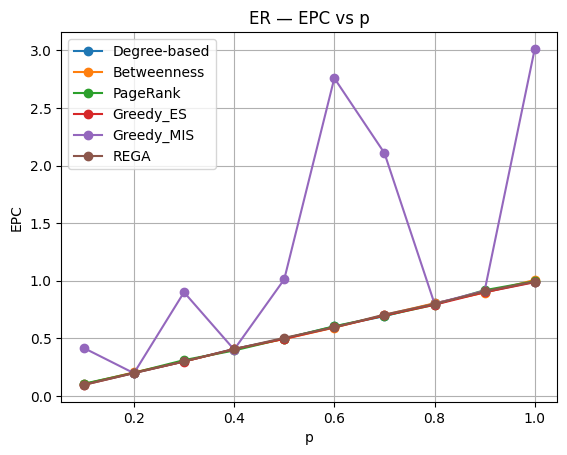

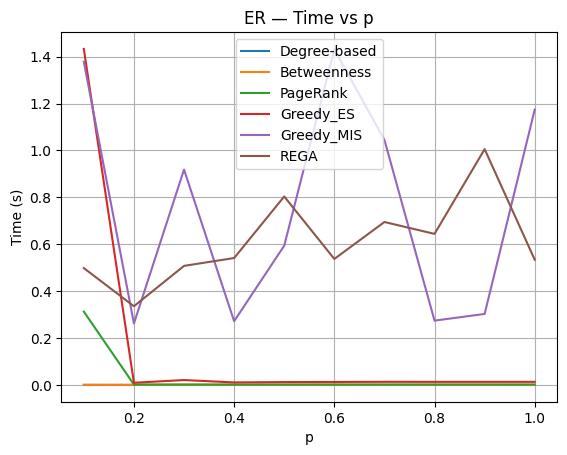

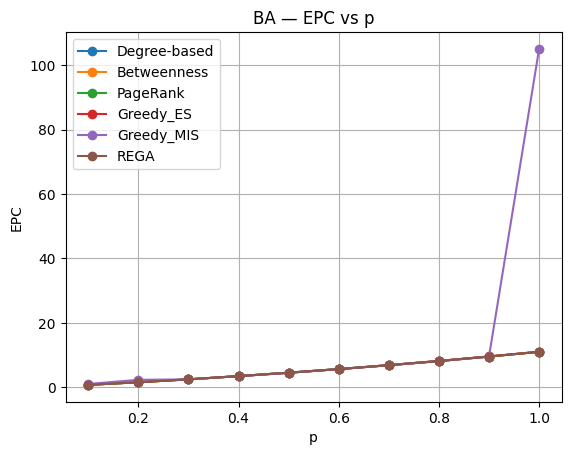

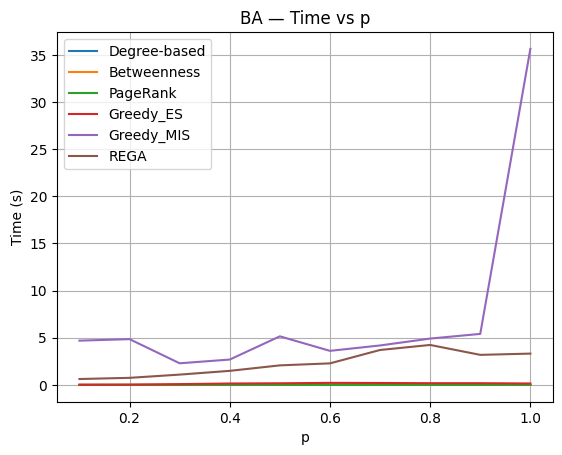

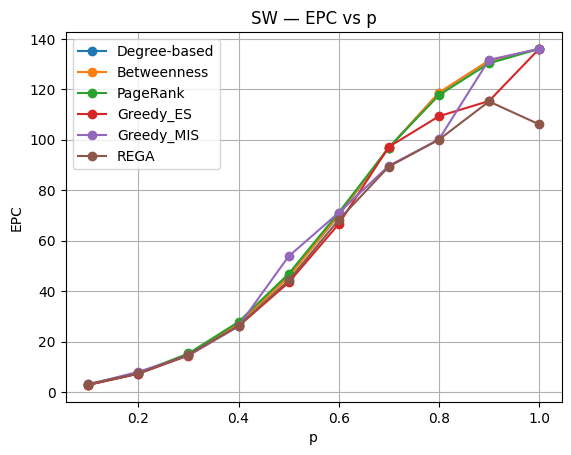

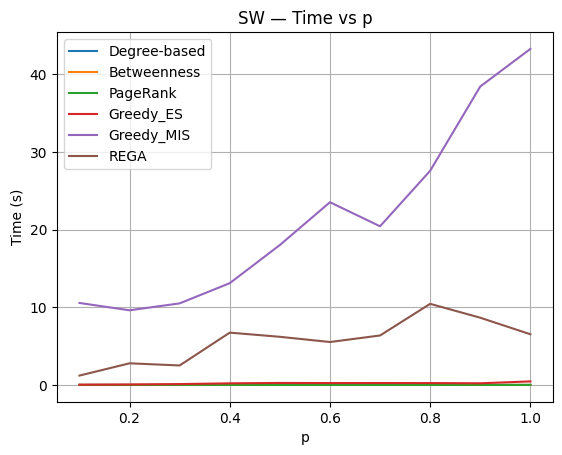

In [ ]:
for name in graph_models:
    plt.figure()
    for algo in df.algo.unique():
        sub=df[(df.model==name)&(df.algo==algo)]
        plt.plot(sub.p, sub.epc, marker='o', label=algo)
    plt.title(f"{name} — EPC vs p")
    plt.xlabel("p"); plt.ylabel("EPC"); plt.grid(True); plt.legend()

    # plt.savefig(f"{name}_time_vs_p.png")
    
    plt.figure()
    for algo in df.algo.unique():
        sub = df[(df.model == name) & (df.algo == algo)]
        plt.plot(sub.p, sub.time, label=algo)
    plt.title(f"{name} — Time vs p")
    plt.xlabel("p"); plt.ylabel("Time (s)"); plt.grid(True); plt.legend()
    # plt.savefig(f"{name}_time_vs_p.png")


plt.show()